In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

import seaborn as sns; sns.set()
sns.set_style("whitegrid")

In [19]:
import numpy as np
#from pygmo.core import hypervolume
import matplotlib. pyplot as plt

def get_hypervolume(scores):
    """Computes the hypervolume of pareto front:
    Arguments:
        scores - the pareto front
    The higer the volume the better the pareto set.
    """
    scores = -scores
    hv = 0#hypervolume(scores)
    d = scores.shape[1]
    return 0#hv.compute([0.0]*d)
    
def is_dominated(p, S):
    """Helper function.
    """
    for s in S:
        if(np.all(s>=p)):
            return True
    return False

def coverage(S1, S2):
    """Computes the coverage scores.
    Arguments:
        S1 - one pareto front.
        S2 - another pareto front.
        
    coverage(S1, S2) gives the proportion of points in S2 weakly dominated by at least one point in S1
    """
    count = 0
    for s in S2:
        if(is_dominated(s, S1)):
            count = count + 1
    return(count/len(S2))

def distance_to_closest_neighbor(s, scores):
    """Helper function.
    """
    min_distance = 2*scores.shape[1]
    for s_j in scores:
        distance = np.sum(abs(s_j - s))
        if(distance < min_distance):
            min_distance = distance
    return(min_distance)


def spacing(scores):
    """Computes the spacing score.
    Arguments:
        scores - the pareto front
    """
    distances = []
    for i, s in enumerate(scores):
        d_i = distance_to_closest_neighbor(s, np.delete(scores, i, axis=0))
        distances.append(d_i)
        # print(d_i)
    distances = np.array(distances)
    d_mean = np.mean(distances)
    
    total=0
    for d in distances:
        total+=((d-d_mean)*(d-d_mean))
    return np.sqrt(total/float(len(scores) - 1))

In [44]:
def identify_pareto(scores):
    # Count number of items
    population_size = scores.shape[0]
    # Create a NumPy index for scores on the pareto front (zero indexed)
    population_ids = np.arange(population_size)
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            # Check if our 'i' pint is dominated by out 'j' point
            if all(scores[j] >= scores[i]) and any(scores[j] > scores[i]):
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
    # Return ids of scenarios on pareto front
    return population_ids[pareto_front]

def get_pareto_points(metric1, metric2):

    scores = np.transpose(np.array([metric1, metric2]))

    x = scores[:, 1]
    y = scores[:, 0]
    
    pareto = identify_pareto(scores)
    pareto_front = scores[pareto]
    
    pareto_front_df = pd.DataFrame(pareto_front)
    pareto_front_df.sort_values(0, inplace=True)
    pareto_front = pareto_front_df.values
    
    x_all = scores[:, 1]
    y_all = scores[:, 0]
    x_pareto = pareto_front[:, 1]
    y_pareto = pareto_front[:, 0]
    
    return x_pareto, y_pareto

def plot_two_pareto(recall1, revenue1, recall2, revenue2):
    pareto_new = get_pareto_points(recall1, revenue1)
    pareto_original = get_pareto_points(recall2, revenue2)
    
    plt.plot(pareto_original[0], pareto_original[1], color='#1f77b4', linewidth=2, marker=".", linestyle='-', markersize=10, label='Vanilla SMSGD')
    #plt.scatter(pareto_original[0], pareto_original[1], color='#ff7f0e', linewidth=2, marker="s", linestyle=':', markersize=7, label='Adamized SMSGD')

    plt.plot(pareto_new[0], pareto_new[1], color='#ff7f0e', linewidth=2, marker="s", linestyle=':', markersize=7, label='Adamized SMSGD')
    #plt.scatter(pareto_new[0], pareto_new[1], color="darkblue")

    plt.xlabel('Revenue@20', fontsize=18)
    plt.ylabel('Recall@20', fontsize=18)
    plt.ylim((0.282, 0.289))
    plt.tick_params(labelsize=18)
    # legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
    legend = plt.legend(prop={'size':14},loc='upper left')
    plt.savefig(PLOTS_DIR + "/6_pareto_front.pdf", bbox_inches='tight', dpi=300)
    plt.show()
    
    pareto_original = np.array(list(zip(pareto_original[0], pareto_original[1])))
    pareto_new = np.array(list(zip(pareto_new[0], pareto_new[1])))
    print("Hypervolume of original: {}".format(get_hypervolume(pareto_original)))
    print("Hypervolume of new: {}".format(get_hypervolume(pareto_new)))
    print("Coverage of original over new: {}".format(coverage(pareto_original, pareto_new)))
    print("Coverage of new over original: {}".format(coverage(pareto_new, pareto_original)))
    print("Spacing of original: {}".format(spacing(pareto_original)))
    print("Spacing of new: {}".format(spacing(pareto_new)))

In [45]:
def plot_one(file_name, new_format=True):
    with open(file_name) as f:
        log_file = f.readlines()
    lines = [x for x in log_file if x.startswith("Trainer: Epoch:")]
    losses = [float(x.split()[8][:-1]) for x in lines]
    if not new_format:
        recall = [float(x.split()[14][1:-1]) for x in lines]
        revenue = [float(x.split()[15][:-2]) for x in lines]
    else:
        recall = [float(x.split()[18][1:-1]) for x in lines]
        revenue = [float(x.split()[19][:-2]) for x in lines]
        loss1 = [float(x.split()[11][1:-1]) for x in lines]
        loss2 = [float(x.split()[12][:-1]) for x in lines]
        
    
    plt.plot(losses)
    plt.ylabel("loss")
    plt.show()
    
    if new_format:
        plt.plot(loss1)
        plt.ylabel("loss 1")
        plt.show()

        plt.plot(loss2)
        plt.ylabel("loss 2")
        plt.show()

    plt.plot(recall)
    plt.ylabel("Recall@20")
    plt.show()

    plt.plot(revenue)
    plt.ylabel("Revenue@20")
    plt.show()

    plot_one_pareto(recall, revenue)
    
def plot_one_pareto(recall1, revenue1):
    pareto_original = get_pareto_points(recall1, revenue1)
    
    plt.plot(pareto_original[0], pareto_original[1], color='y', label="Vanilla SMSGD")
    plt.scatter(pareto_original[0], pareto_original[1])
    
    max_recall = max(recall1)
    max_revenue = max(revenue1)
    plt.scatter([max_revenue], [max_recall], color='orange', marker="*", label="Utopia Solution")

    plt.xlabel('Revenue@20')
    plt.ylabel('Recall@20')
    # legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
    legend = plt.legend()
    plt.savefig(PLOTS_DIR + "/6_pareto_front.pdf", dpi=200)
    plt.show()

In [46]:
def plot_two(file_name1, file_name2, new_format=True):
    with open(file_name1) as f:
        log_file = f.readlines()
    lines = [x for x in log_file if x.startswith("Trainer: Epoch:")]
    losses1 = [float(x.split()[8][:-1]) for x in lines]
    if not new_format:
        recall1 = [float(x.split()[14][1:-1]) for x in lines]
        revenue1 = [float(x.split()[15][:-2]) for x in lines]
    else:
        recall1 = [float(x.split()[18][1:-1]) for x in lines]
        revenue1 = [float(x.split()[19][:-2]) for x in lines]
        loss1_1 = [float(x.split()[11][1:-1]) for x in lines]
        loss1_2 = [float(x.split()[12][:-1]) for x in lines]
    
    with open(file_name2) as f:
        log_file = f.readlines()
    lines = [x for x in log_file if x.startswith("Trainer: Epoch:")]
    losses2 = [float(x.split()[8][:-1]) for x in lines]
    if not new_format:
        recall2 = [float(x.split()[14][1:-1]) for x in lines]
        revenue2 = [float(x.split()[15][:-2]) for x in lines]
    else:
        recall2 = [float(x.split()[18][1:-1]) for x in lines]
        revenue2 = [float(x.split()[19][:-2]) for x in lines]
        loss2_1 = [float(x.split()[11][1:-1]) for x in lines]
        loss2_2 = [float(x.split()[12][:-1]) for x in lines]
    
    plt.plot(losses1, color='b', label="Adamized SMSGD")
    plt.plot(losses2, color='y', label="Vanilla SMSGD")
    plt.ylabel("Loss")
    plt.xlabel("Epcoh")
    legend = plt.legend()
    plt.savefig(PLOTS_DIR + "/1_loss.png", dpi=200)
    plt.show()
    
    if  new_format:
        plt.plot(loss1_1, color='b', label="Adamized SMSGD")
        plt.plot(loss2_1, color='y', label="Vanilla SMSGD")
        plt.ylabel("Relevance loss")
        plt.xlabel("Epcoh")
        legend = plt.legend()
        plt.savefig(PLOTS_DIR + "/2_relevance_loss.png", dpi=200)
        plt.show()
        
        plt.plot(loss1_2, color='b', label="Adamized SMSGD")
        plt.plot(loss2_2, color='y', label="Vanilla SMSGD")
        plt.ylabel("Revenue loss")
        plt.xlabel("Epcoh")
        legend = plt.legend()
        plt.savefig(PLOTS_DIR + "/3_revenue_loss.png", dpi=200)
        plt.show()

    plt.plot(recall1, color='b', label="Adamized SMSGD")
    plt.plot(recall2, color='y', label="Vanilla SMSGD")
    plt.ylabel("Recall@20")
    plt.xlabel("Epcoh")
    legend = plt.legend()
    plt.savefig(PLOTS_DIR + "/4_recall.png", dpi=200)
    plt.show()

    plt.plot(revenue1, color='b', label="Adamized SMSGD")
    plt.plot(revenue2, color='y', label="Vanilla SMSGD")
    plt.ylabel("Revenue@20")
    plt.xlabel("Epcoh")
    legend = plt.legend()
    plt.savefig(PLOTS_DIR + "/5_revenue.png", dpi=200)
    plt.show()
    
    plot_two_pareto(recall1, revenue1, recall2, revenue2)

In [47]:
def print_optim_info(file_name):
    with open(file_name) as f:
        log_file = f.readlines()
    optim_info = [x for x in log_file if x.startswith("Optimiser:")]
    for line in optim_info:
        print(line.strip())

In [48]:
# logs = os.listdir("logs_adam_per_obj_final")
# logs = [os.path.join("logs_adam_per_obj_final", x) for x in logs if x.startswith("run_")]
# logs = sorted(logs)

# for log in logs:
#     print("="*100)
#     print_optim_info(log)
#     plot_two(log, "run_example_original_2020-07-29_21-20-35.log")
#     print(log)

In [49]:
# cherry_picked = [
# "logs_adam_per_obj_final/run_example_adam_per_obj_2020-07-30_06-56-25.log",
# "logs_adam_per_obj_final/run_example_adam_per_obj_2020-07-30_14-18-06.log",
# "logs_adam_per_obj_final/run_example_adam_per_obj_2020-08-02_21-14-42.log",
# "logs_adam_per_obj_final/run_example_adam_per_obj_2020-08-03_00-45-30.log",
# "logs_adam_per_obj_final/run_example_adam_per_obj_2020-08-03_04-16-39.log",
# "logs_adam_per_obj_final/run_example_adam_per_obj_2020-08-03_07-42-51.log",
# ]

# for log in cherry_picked:
#     print("="*100)
#     print_optim_info(log)
#     plot_two(log, "run_example_original_2020-07-29_21-20-35.log")
#     print(log)

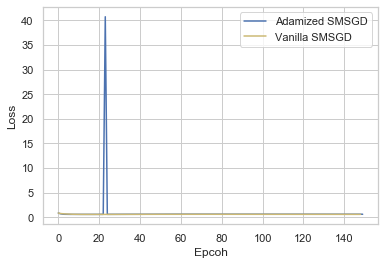

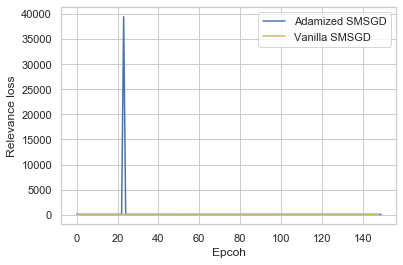

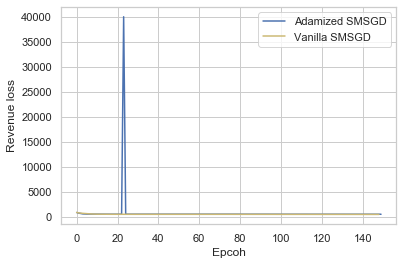

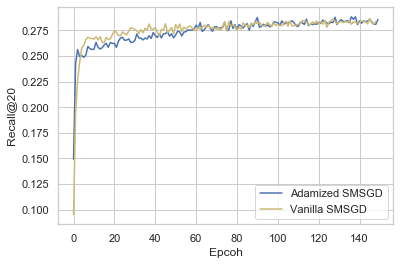

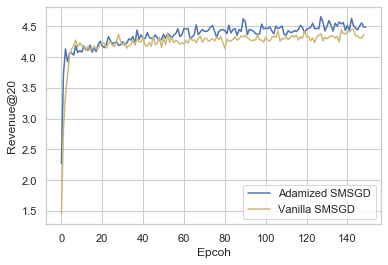

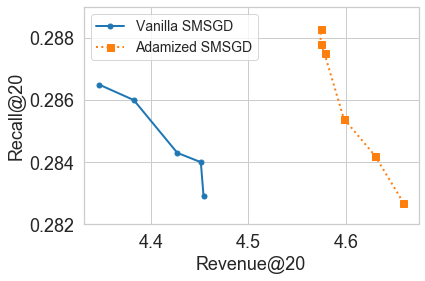

Hypervolume of original: 0
Hypervolume of new: 0
Coverage of original over new: 0.0
Coverage of new over original: 1.0
Spacing of original: 0.016266745218389864
Spacing of new: 0.01442780879644121


In [50]:
PLOTS_DIR = "plots_ADAMIZE"
if not os.path.exists(PLOTS_DIR):
    os.mkdir(PLOTS_DIR)
plot_two("logs_adam_per_obj_final/run_example_adam_per_obj_2020-08-03_00-45-30.log", "run_example_original_2020-07-29_21-20-35.log")

In [ ]:
#plot_two("logs_adam_per_obj_final/run_example_adam_per_obj_2020-07-30_06-56-25.log", "run_example_original_2020-07-29_21-20-35.log")

In [23]:
# plot_one("run_example_original_2020-07-29_21-20-35.log")